In [4]:
from dataset.cldataset import CLDataset
from dataset.cifar10 import CIFAR10Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd

In [5]:
class MockConfig:
    def __init__(self):
        self.debug = True

# Example usage
cfg = MockConfig()  # Replace with actual config object

train_dataset = CIFAR10Dataset(
    root='/home/hamt/cll_vlm/cll_vlm/data/cifar10',
    train=True,
    transform=None  # No transform for visualization
)
train_dataset.cfg = cfg
original_dataset, shuffled_dataset = train_dataset.get_shuffled_labels_dataset()
print(f"Original dataset size: {len(original_dataset)}")
print(f"Shuffled dataset size: {len(shuffled_dataset)}")

Created shuffled dataset:
  - Original dataset: 50000 samples
  - Shuffled dataset: 50000 samples
  - Labels shuffled: True
Original dataset size: 50000
Shuffled dataset size: 50000


In [6]:
from torchvision import transforms

from models.llava_classifier import LLaVAClassifier

In [7]:
# Init classifier
classifier = LLaVAClassifier(
    model_path="liuhaotian/llava-v1.5-7b",
    device_map="auto",        # multi-GPU
    load_in_8_bit=True
)

/home/hamt/.conda/envs/cll_llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/home/hamt/.conda/envs/cll_llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.04s/it]


Classifying: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]

Results saved to cifar10_llava_test_results.csv
   index true_label random_label predicted raw_answer
0      0       frog         bird        CL         No
1      1      truck        truck        OL        Yes
2      2      truck        horse        CL         No


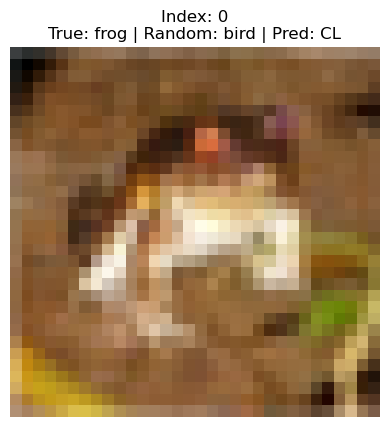

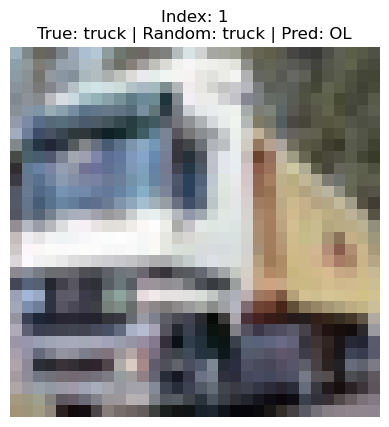

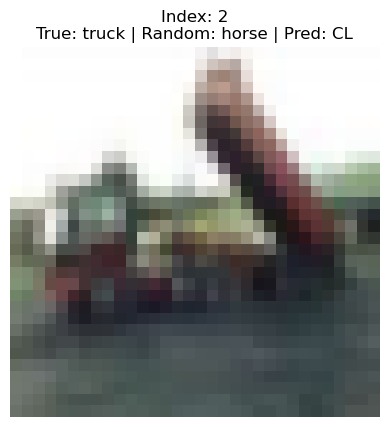

In [8]:
# Test trên 5 ảnh
df_results = classifier.classify(original_dataset,
                                       shuffled_dataset,
                                       num_samples=3,
                                       save_path="cifar10_llava_test_results.csv")

print(df_results)

# Hiển thị ảnh và thông tin
for row in df_results.itertuples():
    img, _ = original_dataset[row.index]
    plt.imshow(img)
    plt.title(f"Index: {row.index}\nTrue: {row.true_label} | Random: {row.random_label} | Pred: {row.predicted}")
    plt.axis("off")
    plt.show()

### chạy toàn bộ dataset

Classifying: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Results saved to cifar10_llava_test_results.csv
<bound method NDFrame.head of     index  true_label random_label predicted raw_answer
0       0        frog         bird        CL         No
1       1       truck        truck        OL        Yes
2       2       truck        horse        CL         No
3       3        deer         frog        CL         No
4       4  automobile         frog        OL        Yes
..    ...         ...          ...       ...        ...
95     95        frog     airplane        CL         No
96     96  automobile        truck        OL        Yes
97     97  automobile         frog        OL        Yes
98     98        deer         frog        CL         No
99     99  automobile          cat        CL         No

[100 rows x 5 columns]>


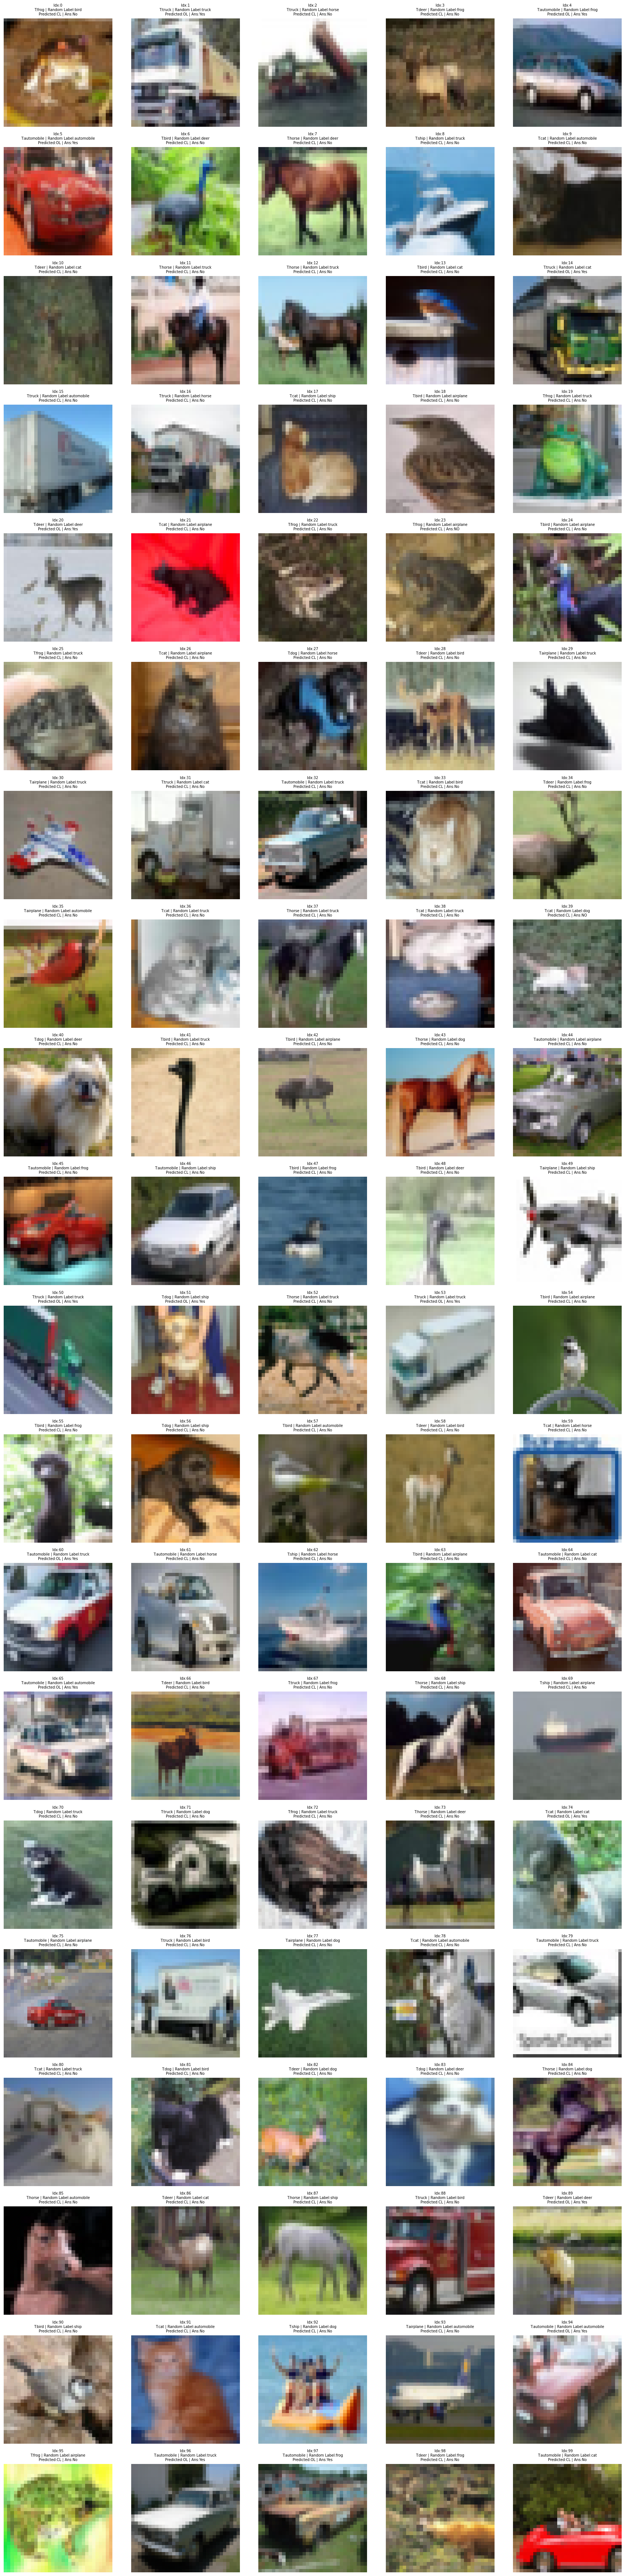

In [9]:
df_results = classifier.classify(original_dataset,
                                       shuffled_dataset,
                                       num_samples=100,
                                       save_path="cifar10_llava_test_results.csv")

print(df_results.head)

# Hiển thị ảnh và thông tin
def show_images_grid(df_results, original_dataset, num_images=20, per_row=5):
    rows = (num_images + per_row - 1) // per_row
    fig, axes = plt.subplots(rows, per_row, figsize=(per_row * 3.5, rows * 3.5))

    axes = axes.flatten()

    for i, row in enumerate(df_results.itertuples()):
        if i >= num_images:
            break
        img, _ = original_dataset[row.index]
        axes[i].imshow(img)
        axes[i].set_title(
            f"Idx:{row.index}\n"
            f"T:{row.true_label} | Random Label:{row.random_label}\n"
            f"Predicted:{row.predicted} | Ans:{row.raw_answer}",
            fontsize=7
        )
        axes[i].axis("off")

    # Ẩn các subplot thừa
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

show_images_grid(df_results, original_dataset, num_images=100, per_row=5)

### Plotting

In [13]:
def plot_random_label_distribution(csv_path):
    # Đọc file
    df = pd.read_csv(csv_path)

    # Đếm tần suất random_label
    counts = df["random_label"].value_counts()

    # Vẽ biểu đồ
    plt.figure(figsize=(10,6))
    counts.plot(kind="bar")
    plt.title("Distribution of Random Labels")
    plt.xlabel("Random Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

In [14]:
import seaborn as sns

def plot_transition_matrix(original_dataset, shuffled_dataset):
    n_classes = len(original_dataset.classes)
    matrix = np.zeros((n_classes, n_classes), dtype=int)

    for orig, shuf in zip(original_dataset.targets, shuffled_dataset.targets):
        matrix[orig, shuf] += 1

    df_matrix = pd.DataFrame(matrix, index=original_dataset.classes, columns=original_dataset.classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_matrix, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
    plt.title("Transition Matrix: True → Shuffled")
    plt.xlabel("Shuffled Label")
    plt.ylabel("True Label")
    plt.show()

    return df_matrix

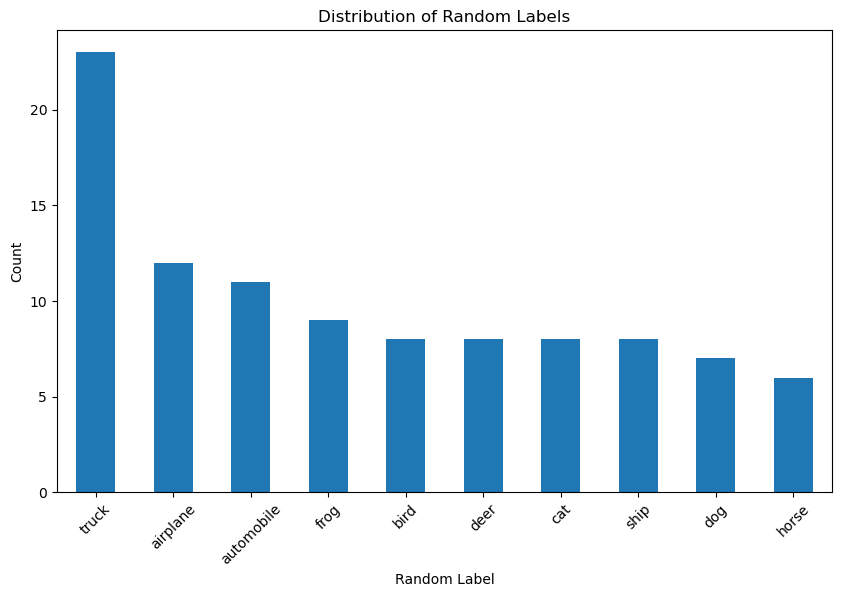

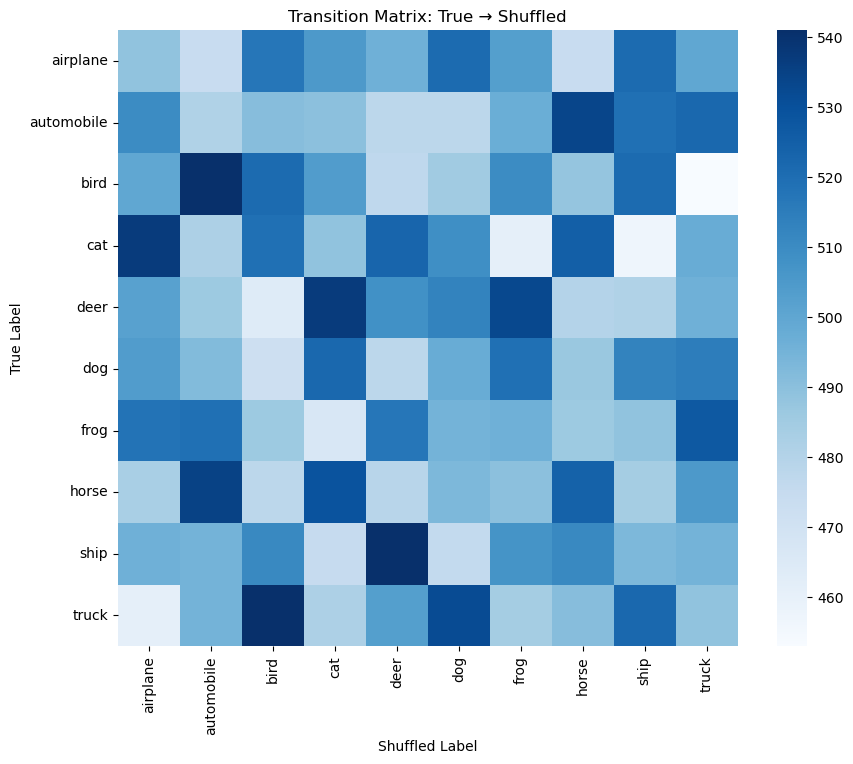

In [16]:
file_path = "/home/hamt/cll_vlm/cll_vlm/cifar10_llava_test_results.csv"

plot_random_label_distribution(file_path)
transition_matrix = plot_transition_matrix(original_dataset, shuffled_dataset)

In [17]:
import pandas as pd

file_path = "/home/hamt/cll_vlm/cll_vlm/cifar10_llava_test_results.csv"
df = pd.read_csv(file_path)

cond1 = ((df["true_label"] == df["random_label"]) & (df["raw_answer"].str.lower() == "no"))

cond2 = ((df["true_label"] != df["random_label"]) & (df["raw_answer"].str.lower() == "yes"))

wrong = df[cond1 | cond2]

wrong

,index,true_label,random_label,predicted,raw_answer
4,4,automobile,frog,OL,Yes
14,14,truck,cat,OL,Yes
51,51,dog,ship,OL,Yes
60,60,automobile,truck,OL,Yes
96,96,automobile,truck,OL,Yes
97,97,automobile,frog,OL,Yes
